<h1>Modeling of a Catheter <br>for Cardiac Ablation</h1>
<p>Daniel Newman <br>
<a href="mailto:danielnewman09@gmail.com">danielnewman09@gmail.com</a> <br>
<a href="http://danielnewman09.github.io">http://danielnewman09.github.io</a> <br>

<h2 id="Creating-the-Full-Model">Creating the Full Model</h2>
<img src="https://cdn.rawgit.com/danielnewman09/Catheter-Ablation/master/manuscript/Figures/Planar_Model.svg" align="middle">
<p style="text-align:center;"><strong>Figure 1: Dynamic model of a two link flexible-arm manipulator</strong></p><br>

The dynamic model used in this analysis is shown in Fig. 1. A flexible beam is assumed to be fixed at its base. The rotation of each element about the $\bar{Z}$-axis is designated by $\theta_{i}$, where $i$ is the element number. As depicted in this Figure, each rotation is defined relative to the global coordinate frame. The generalized coordinates are arranged in the following form:

\begin{equation}
Q_{n \times 1} = 
\begin{bmatrix}
 \theta_{1} & 
 \theta_{2} &
 \dots & 
 \theta_{n} & 
\end{bmatrix}^T.
\end{equation}

<h3 id="System-Inputs">System Inputs</h3>

The input to the system is given as force applied to the distal tip of the $n^{th}$ element, $f$. In addition, a known velocity field, $\vec{U}$, exerts drag forces on each element. These drag forces generate moments at each hinge, causing deflection of the catheter. These moments are given by:

\begin{equation}
\vec{\gamma}_{n} = \int_{0}^{l_n} \vec{r}_n(x) \times \vec{f}_n(x) \mathrm{d}x,
\end{equation}

where:

\begin{equation}
\vec{r}(x)_n = x \mathbf{\hat{i}_n} + 0 \mathbf{\hat{j}_n} + \mathbf{\hat{k}_n},
\end{equation}

is a displacement vector pointing from the element origin to a point along its length, $\vec{f}_n(x)$ is the location-dependent force vector due to hemodynamic forces, and $\vec{\gamma}_{n}$, is the resultant torque acting at the element origin. 

The drag induced by hemodynamic flow is:

\begin{equation}
\vec{f}_n(x,t) = \frac{1}{2}\rho C_d D 
\begin{bmatrix}
\cos{\theta_n} & -\sin{\theta_n} \\
\sin{\theta_n} & \cos{\theta_n}
\end{bmatrix}
\vec{U}(x,t),
\end{equation}

where $\rho$ is the mass density of blood, $C_d$ is the drag coefficient of the catheter, $D$ is the diameter of its cross-section, and $\vec{U}(x)$ is the flow field, given in the inertial coordinate frame. Note that this model ignores wall shear. The resulting total exogenous input is therefore given by:

\begin{equation}
\Gamma_{n \times 1} = 
\begin{bmatrix}
\gamma_{2} &  
\dots & 
\gamma_{n-1} & 
\gamma_{n}
\end{bmatrix}^T,
\end{equation}

where the torque applied to the first element is ignored due to the fixed boundary condition.

<h3 id="Internal-Moments">Internal Moments</h3>

Each generalized coordinate also has an associated internal moment based on its material properties. The internal bending moment for each element is given by:

\begin{equation}
\begin{aligned}
M_{n} &= \frac{EI (\theta_{n} - \theta_{n-1})}{l_n + l_{n-1}}, \\
\end{aligned}
\end{equation}

These moments are found by discretizing standard Euler-Bernoulli beam theory. 

<h3 id="Equations-of-Motion">Equations of Motion</h3>

The resulting equations of motion were created by Kane's method using the Python SymPy module. When linearized about $Q=\dot{Q}=0$, the state-space representation of the dynamic system is given by:

\begin{equation}
\label{eq:eqmotion}
\begin{bmatrix}
 \dot{Q}\\
 \ddot{Q}
\end{bmatrix} =
A
\begin{bmatrix}
 Q\\
 \dot{Q}
\end{bmatrix}
+
B f_{in}
+
\Omega \Gamma
\end{equation}

where $A$ and $B$ are the linearized state transition and input matrices, and $\Omega$ is the disturbance input matrix.  

Because \eqref{eq:eqmotion} is linearized, it will degrade in performance at large tip deflections. This degradation is increased due to the use of Euler-Bernoulli beam theory, which is strictly valid for small deflections. However, this model serves as a foundation from which dynamic and control properties can be evaluated.

<h2 id="Sympy-Deriv">Using SymPy to create the full equations of motion</h2>

The following Python code can be used to create the equations of motion via Kane's method. 


<h3 id="Import-Python-Libraries">Import Python Libraries</h3>

We first need to start by importing all relevant Python libraries.

In [1]:
# Sympy libraries to symbolically create system models
from sympy import symbols
from sympy.physics import mechanics
from sympy.physics.mechanics import dynamicsymbols
import sympy.physics.mechanics as me
from sympy.physics.mechanics import inertia
from sympy import Dummy, lambdify
from sympy import Matrix

# Scipy libraries to optimize and integrate
from scipy import integrate
from scipy.integrate import odeint
from scipy.optimize import minimize

# Numpy library to perform computational heavy lifting
import numpy as np

# Crawlab plotting toolbox to generate nice plots
# import crawlab_toolbox.plotting as plot

from matplotlib.animation import writers
from matplotlib import animation, rc
from matplotlib import pyplot as plt
import matplotlib as mpl

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import HTML

In [173]:
def derive_sys(n,p):
    """Derive the equations of motion using Kane's method"""
    #-------------------------------------------------
    # Step 1: construct the catheter model
    
    # Generalized coordinates and velocities
    # (in this case, angular positions & velocities of each mass) 
    q = mechanics.dynamicsymbols('q:{0}'.format(n))
    u = mechanics.dynamicsymbols('u:{0}'.format(n))
    
    # Torques applied to each element due to external loads
    Torque = dynamicsymbols('tau:{0}'.format(n))
    
    # Force applied at the end of the catheter by the user
    F_in = dynamicsymbols('F:{0}'.format(1))

    # Unpack the system values
    M, L, E, I = p
    
    # Structural damping 
    damp = 1e-1

    lengths = np.concatenate([np.broadcast_to(L / n,n)])    
    masses = np.concatenate([np.broadcast_to(M / n,n)])

    # time symbol
    t = symbols('t')
    
    # The stiffness of the internal springs simulating material stiffness
    stiffness = E * I
    
    #--------------------------------------------------
    # Step 2: build the model using Kane's Method

    # Create pivot point reference frame
    A = mechanics.ReferenceFrame('A')
    P = mechanics.Point('P')
    P.set_vel(A,0)

    # lists to hold particles, forces, and kinetic ODEs
    # for each pendulum in the chain
    particles = []
    forces = []
    kinetic_odes = []
    
    # Create a rotated reference frame for the first rigid link
    Ar = A.orientnew('A' + str(0), 'axis', [q[0],A.z])

    # Create a point at the center of gravity of the first link
    Gr = P.locatenew('G' + str(0),(lengths[0] / 2) * Ar.x)
    Gr.v2pt_theory(P,A,Ar)
    
    # Create a point at the end of the link
    Pr = P.locatenew('P' + str(0), lengths[0] * Ar.x)
    Pr.v2pt_theory(P, A, Ar)   

    # Create the inertia for the first rigid link
    Inertia_r = inertia(Ar,0,0,masses[0] * lengths[0]**2 / 12)

    # Create a new particle of mass m[i] at this point
    Par = mechanics.RigidBody('Pa' + str(0), Gr, Ar, masses[0], (Inertia_r,Gr))
    particles.append(Par)
    
    # Add an internal spring based on Euler-Bernoulli Beam theory
    forces.append((Ar, -stiffness * (q[0]) / (lengths[0]) * Ar.z))
    
    # Add a damping term
    forces.append((Ar, (-damp * u[0]) * Ar.z))

    #next_torque = 0
    #for j in range(0,n):
    #    next_torque += Torque[j]
    #else:
    #    next_torque = 0.
    #forces.append((Ar,(Torque[0] + next_torque) * Ar.z))


    # Add a new ODE term
    kinetic_odes.append(q[0].diff(t) - u[0])
    
    P = Pr
    
    for i in range(1,n):
        
        # Create a reference frame following the i^th link
        Ai = A.orientnew('A' + str(i), 'Axis', [q[i],A.z])
        Ai.set_ang_vel(A, u[i] * Ai.z)
        
        # Set the center of gravity for this link
        Gi = P.locatenew('G' + str(i),lengths[i] / 2 * Ai.x)
        Gi.v2pt_theory(P,A,Ai)

        # Create a point in this reference frame
        Pi = P.locatenew('P' + str(i), lengths[i] * Ai.x)
        Pi.v2pt_theory(P, A, Ai)
        
        # Set the inertia for this link
        Inertia_i = inertia(Ai,0,0,masses[i] * lengths[i]**2 / 12)

        # Create a new particle of mass m[i] at this point
        Pai = mechanics.RigidBody('Pa' + str(i), Gi, Ai, masses[i], (Inertia_i,Gi))
        particles.append(Pai)
        
        # The external torques influence neighboring links
        if i + 1 < n:
            next_torque = 0
            for j in range(i,n):
                next_torque += Torque[j]
        else:
            next_torque = 0.
        forces.append((Ai,(Torque[i] + next_torque) * Ai.z))
        
        # Add another internal spring
        forces.append((Ai, (-stiffness * (q[i] - q[i-1]) / (2 * lengths[i])) * Ai.z))
        
        # Add the damping term
        forces.append((Ai, (-damp * u[i]) * Ai.z))

        kinetic_odes.append(q[i].diff(t) - u[i])

        P = Pi
    
    # Add the user-defined input at the tip of the catheter, pointing normal to the 
    # last element
    forces.append((P, F_in[0] * Ai.y))

    # Generate equations of motion
    KM = mechanics.KanesMethod(A, q_ind=q, u_ind=u,
                               kd_eqs=kinetic_odes)
    fr, fr_star = KM.kanes_equations( particles, forces)

    return KM, fr, fr_star, q, u, Torque, F_in, lengths, masses

<h3 id="Create-Numerical-Functions">Create Numerical Functions</h3>

With the symbolic equations of motion, we should create functions which can numerically capture the dynamics.

In [174]:
def parameterize(n,kane):
    """
    Parameterize the symbolic equations of motion so that they can be integrated 
    
    Inputs:
        n - number of elements
        kane - full nonlinear equations of motion

    Outputs: 
        mm_func - mass matrix function
        fo_func - forcing matrix function
    """

    # Unpack the kanes method parameters
    KM, fr, fr_star, q, u, tau, force_in, lengths, masses = kane

    
    # define symbols for unknown parameters
    unknowns = [Dummy() for i in q + u + tau + list(force_in)]
    unknown_dict = dict(zip(q + u + tau + list(force_in), unknowns))
    kds = KM.kindiffdict()

    # substitute unknown symbols for qdot terms
    mm_sym = KM.mass_matrix_full.subs(kds).subs(unknown_dict)
    fo_sym = KM.forcing_full.subs(kds).subs(unknown_dict)

    # create functions for numerical calculation 
    mm_func = lambdify(unknowns, mm_sym)
    fo_func = lambdify(unknowns, fo_sym)

    return mm_func,fo_func
    

<h3 id="Linearizing-the-Equations-of-Motion">Linearizing the Equations of Motion</h3>

The following python code can be used to linearize the equations of motion

In [175]:
def linearize_system(n,kane):
    """
    Take the previously derived equations of motion and create an LTI model
    
    Inputs:
        n - number of elements
        kane - full nonlinear equations of motion
        p - packed parameters (must have values)
    
    Outputs:
        A_np - Linearized A matrix as a numpy array
        B_np - Linearized B matrix as a numpy array
    """

    # Unpack the kanes method parameters
    KM, fr, fr_star, q, u, Torque, F_in, lengths, masses = kane

    # Linearize the Kane's method equations
    linearizer = KM.to_linearizer()
    
    # Output the A, B, and Mass matrices
    Maz, A, B = linearizer.linearize()
    
    # Create an operating point around which we will linearize
    op_point = dict()

    # we will linearize about the undeflected, stationary point
    for h in range(n):
        op_point[q[h]] = 0.0
        op_point[u[h]] = 0.0
    
    # Perform substitutions to solve for the linearized matrices
    M_op = me.msubs(Maz, op_point)
    A_op = me.msubs(A, op_point)
    B_op = me.msubs(B, op_point)
    perm_mat = linearizer.perm_mat

    # Solve for the linear A and B matrices
    A_lin = perm_mat.T * M_op.LUsolve(A_op)
    B_lin = perm_mat.T * M_op.LUsolve(B_op)
    A_sol = A_lin.subs(op_point).doit()
    B_sol = B_lin.subs(op_point).doit()

    # Ensure the matrices are of the correct data type
    A_np = np.array(np.array(A_sol), np.float)
    B_np = np.array(np.array(B_sol), np.float)

    return A_np,B_np

<h2 id="Derive-the-Tip-Output">Derive the Tip Output</h2>

In order to understand how a controller works for this system, we need to have an understanding of how the tip of the catheter is moving. These python functions can provide that information.

In [176]:
def body_rotation(coords,angle):
    """
    Rotate a body in a two-dimensional coordinate frame
    
    Inputs:
        coords - [2xn] array of coordinates in the current frame
        angle - [1xn] array of angles about which the frame is rotated
    
    Outputs:
        x - X-coordinate in the rotated frame
        y - Y-coordinate in the rotated frame
    """
    
    # Rotation about the z-axis
    def R_z(theta):
        rotation = np.zeros([len(theta),2,2])
        rotation[:,0,0] = np.cos(theta)
        rotation[:,0,1] = -np.sin(theta)
        rotation[:,1,0] = np.sin(theta)
        rotation[:,1,1] = np.cos(theta)
        return rotation
    
    # Perform the rotation
    rotated_coords = np.matmul(R_z(angle[:]), coords)
    
    # Extract the x and y coordinates
    x = rotated_coords[:,0,0]
    y = rotated_coords[:,1,0]

    return x,y


def get_xy_coords(n,q, lengths):
    """
    Get (x, y) coordinates of the beam from generalized coordinates q
    
    Inputs:
        n - number of elements
        q - generalized coordinates
        lengths - length of each element
    
    Outputs:
        x_coords - X-coordinates of each beam element
        y_coords - Y-coordinates of each beam element
    """
    
    q = np.atleast_2d(q)

    zeros = np.zeros(q.shape[0])[:, None]

    x = np.hstack([zeros])
    y = np.hstack([zeros])

    for i in range(0,n):
        
        # Get the new x and y coordinates to append 
        x_app,y_app = body_rotation(np.array([[lengths[i]],[0]]),q[:,i])
        
        # Append to the matrices
        x = np.append(x,np.atleast_2d(x_app).T,axis=1)
        y = np.append(y,np.atleast_2d(y_app).T,axis=1)
    
    x_coords = np.cumsum(x,1)
    y_coords = np.cumsum(y,1) 

    return x_coords, y_coords

def get_xy_deriv(n,q, lengths):
    """
    Get (x_dot, y_dot) coordinates from generalized coordinates q

    Inputs:
        n - number of elements
        q - generalized coordinates
        lengths - length of each element
    
    Outputs:
        x_dot_coords - X_dot-coordinates of each beam element
        y_dot_coords - Y_dot-coordinates of each beam element
    
    """
    
    q = np.atleast_2d(q)

    zeros = np.zeros(q.shape[0])[:, None]
    x_dot = np.hstack([zeros])
    y_dot = np.hstack([zeros])

    # Do this for each element
    for i in range(0,n):
    
        # Get the new x_dot and y_dot coordinates to append
        x_app = -lengths[i] * np.sin(q[:,i]) * q[:,i + (n)]
        y_app = lengths[i] * np.cos(q[:,i]) * q[:,i + (n)]
        
        x_dot = np.append(x_dot,np.atleast_2d(x_app).T,axis=1)
        y_dot = np.append(y_dot,np.atleast_2d(y_app).T,axis=1)

    x_dot_coords = np.cumsum(x_dot,1)
    y_dot_coords=  np.cumsum(y_dot,1)
 
    return x_dot_coords,y_dot_coords

<h2 id="Create-an-External-Disturbance">Create an External Disturbance</h2>

Now, let's create an external disturbance on the catheter. For now, let's assume a uniform, periodic flow field.

In [177]:
def force(coords,r,time):
    ''' 
    Get the force resulting from flow on a cylinder in two dimensions
    
    Inputs:
        Coords - location of the current element in the global coordinate frame
        r - displacement vector from the origin of the element
        time - current time 
    
    Outputs:
        F - [2x1] array containing X and Y forces in the reference coordinate frame
    '''
    
    # Maximum velocity of the flow field in m/s
    flow_amp = 0.00
    
    # Flow field velocity
    u_y = flow_amp * np.cos(1. * np.pi * time) + flow_amp # m/s
    
    #  Drag coefficient
    Cd = 1.2 
    
    # Mass density of blood
    rho_blood = 1060 # kg/m^3
    
    # Diameter of the catheter
    Diam = 2.667e-3 # m
    
    # Length projected into the X-axis
    projected_length = r[0]
    
    # Drag force
    F_dy = 0.5 * u_y * rho_blood * Cd * Diam * projected_length
    
    # Ignoring forces in the x-direction for now
    f_x = 0.

    return np.array([[f_x],[F_dy]])

def get_forces(n,q,lengths,time=0.):
    """
    Get the resulting torques acting on the catheter at this instant in time
    
    Inputs:
        n - number of elments
        q - generalized coordinates
        lengths - lengths of each elements
        time - current time in the simulation
    
    Outputs:
        tau - torques along each hinge in the Z direction
    """
    
    # Get the x and y coordinates of the beam
    x,y = get_xy_coords(n,q,lengths)

    # For each origin point of each link, integrate the cross product of the 
    # position vector for the link with the  force converted into the link frame.
    # Return the torques in a way that can be added to the state variables when
    # integrating

    tau = np.zeros(n)
    
    # for each element
    for i in range(0,n):
        
        # Get the displacement of this element
        angles = np.atleast_2d(q[i])
        
        # Because we want to rotate from the global coordinate frame into 
        # the local frame for each element, we will use the negative rotation
        # angle in our calculations
        angles = -angles

        frame_origin = np.array([[x[0,i]],
                                 [y[0,i]]])

        # Direction vector pointing along the X-direction of the desired link
        # This vector is defined in the global coordinate frame
        r = np.array([[x[0,i] - x[0,i-1]],
                      [y[0,i] - y[0,i-1]]])

        # Unit vector pointing in the direction aligned with the link
        # This vector is divided by L, which is the magnitude of r
        u = r / lengths[i]
        
        # Get the projected force on the element at position "x"
        proj_force = lambda x: np.array([foo[0] for foo in body_rotation(force(x * u + frame_origin,r,time),angles)])
        
        # Compute the torque applied by the force at position "x"
        torquez = lambda x: np.cross(np.array([x,0]),np.array(list(proj_force(x))).flatten())
   
        # The total torque applied to the element is the integral of the torque
        # across its length
        torques = np.array([integrate.quad(torquez,0,lengths[i])[0]])

        tau[i] = torques
        
    return tau

<h2>Compare the Linearized and Full Nonlinear Equations</h2>

We linearized the equations of motion to simplify computation time and provide for a model that we can use to control the system. Let's see how closely it performs to the full nonlinear system.

We first need to derive the linear and nonlinear systems based on some physical parameters.


<h3 id="Derive-System">Derive System</h3>

<h4 id="Define-System-Parameters">Define System Parameters</h4>

In [178]:
# Number of elements
n = 5

# Total length
L = 10 # m

# Young's Modulus
E = 69e9

# Diameter = 1 inch
r = 0.0254 / 2

# Moment of inertia. Units = m^4
I = np.pi * r ** 4 / 4

# mass density in kg/m^3
rho = 2.71e3

M = np.pi * r ** 2 * L * rho

# Moment of inertia
# I = 1

p = [M, L, E, I]

<h4 id="Create-Nonlinear-and-Linear-System">Create Linear and Nonlinear System</h4>

In [179]:
kane = derive_sys(n,p)
funcs = parameterize(n,kane)

KM, fr, fr_star, q, u, Torque, F_in, lengths, masses = kane

In [180]:
Torque

[tau0(t), tau1(t), tau2(t), tau3(t), tau4(t)]

In [181]:
A,B = linearize_system(n,kane)
B

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.00301756, -0.37116002, -0.08600049, -0.1629483 , -0.14484294],
       [-0.01508781,  0.76344298, -0.11617611,  0.26856294,  0.17803611],
       [ 0.05733366, -0.49789759,  0.55070491, -0.3651249 , -0.02112293],
       [-0.21424684,  0.13579025, -0.44810783,  0.64575809, -0.0935444 ],
       [ 0.79965371, -0.04526342,  0.14936928, -0.57937175,  0.39530051]])

<h3 id="Define-Response-Functions">Define Response Functions</h3>

In [182]:
def nonlinear_response(n,args,funcs,control_args):
    """
    Create a response from the nonlinear equations of motion
    
    Inputs:
        n - number of elements
        args - response-specific arguments
            f_max - maximum force allowed by the actuator
            time - time array for the simulation
            X0 - initial values for the catheter model
            y_desired - desired tip location for the y-coordinate 
        funcs - nonlinear parameterized functions
            mm_func - mass matrix function
            fo_func - forcing matrix function
        control_args - arguments regarding control
            Kp - proportional gain
            Kd - derivative gain
            use_control - option to use PD control or let the catheter move uncontrolled
    
    Outputs:
        response - integrated equations of motion
    """
    
    # Unpack arguments
    f_max, time, X0, y_desired,lengths = args
    kp,kd,use_control = control_args
    mm_func,fo_func = funcs
   
    # Define the initial conditions
    q_i = np.array(X0[0])
    u_i = np.array(X0[1])

    # initial positions and velocities – assumed to be given in degrees
    y0 = np.concatenate([np.tile(q_i,n),np.tile(0,n-1), np.array([u_i])])
    
    print(y0)
    
    tau = np.zeros(n)
    force_in = np.zeros(1)
    
    # function which computes the derivatives of parameters
    def gradient(x, currtime,t_sys,tau,force_in):
        
        # Use this option to show a controlled or uncontrolled catheter
        if use_control:
            
            # Get the current x and y coordinates of the catheter
            curr_x,curr_y = get_xy_coords(n,x,lengths)
            curr_x_dot,curr_y_dot = get_xy_deriv(n,x,lengths)

            # Use proportional-Derivative control on the tip y-coordinate
            force_in[0] = kp * (y_desired - curr_y[0,-1]) + kd * (0 - curr_y_dot[0,-1])
        else:
            force_in[0] = 0.
        
        # Get forces from the external disturbance
        tau = get_forces(n,x,lengths,currtime)
        
        # Solve the equations at this time step
        vals = np.concatenate((x, tau , force_in))
        
        sol = np.linalg.solve(mm_func(*vals), fo_func(*vals))

        return np.array(sol).T[0]

    return odeint(gradient, y0, time, args=(time,tau, force_in))

In [183]:
def linear_response(n,A,B,args,control_args):
    """
    Create a response from the linear equations of motion
    
    Inputs:
        n - number of elements
        A - A matrix for the linear equations of motion
        B - B matrix for the linear equations of motion
        args - response-specific arguments
            f_max - maximum force allowed by the actuator
            time - time array for the simulation
            X0 - initial values for the catheter model
            y_desired - desired tip location for the y-coordinate 
        control_args - arguments regarding control
            Kp - proportional gain
            Kd - derivative gain
            use_control - option to use PD control or let the catheter move uncontrolled
    
    Outputs:
        response - integrated equations of motion
    """
    
    # Unpack arguments
    f_max, time, X0, y_desired,lengths = args
    kp,kd,use_control = control_args

    # Create the initial conditions
    q_i = np.array(X0[0])
    u_i = np.array(X0[1])

    # initial positions and velocities – assumed to be given in degrees
    y0 = np.concatenate([np.tile(q_i,n),np.tile(0,n-1), np.array([u_i])])
    
    print(y0)
    
    force_in = np.zeros(B.shape[1])

    # function which computes the derivatives of parameters
    def gradient(x, currtime, t_sys):
        
        tau = np.zeros(n)

        # Use this option to show a controlled or uncontrolled catheter
        if use_control:
            
            # Get the current x and y coordinates of the catheter
            curr_x,curr_y = get_xy_coords(n,x,lengths)
            curr_x_dot,curr_y_dot = get_xy_deriv(n,x,lengths)

            # Use proportional-Derivative control on the tip y-coordinate
            force_in[0] = kp * (y_desired - curr_y[0,-1]) + kd * (0 - curr_y_dot[0,-1])
        else:
            force_in[0] = 0.
        
        # Get torques from the external disturbance
        force_in[1:] += get_forces(n,x,lengths,currtime)[1:]
        
        # apply the external torques to the input vector
        #force_in = tau
        
    
        # Solve the equation of motion
        sol = np.matmul(A,x) + np.matmul(B,force_in)
        
        return np.array(sol)

    return odeint(gradient, y0, time, args=((time,)))

<h3 id="Create-Responses">Create Responses</h3>

<h4 id="Define-Response-Parameters">Define Response Parameters</h4>

In [185]:
# Initial positions and velocities
theta0_z = 0.
theta0dot_z = 2.

X0 = np.array([theta0_z,theta0dot_z])
# X0 = np.repeat(X0,n)
# Maximum allowable actuator effort
force_max = .01

# Time information
dt = 0.01
tmax = 25.
time = np.arange(0,tmax,dt)

# Desired y-coordinate of the tip
y_desired = L/2

# Control parameters
kp = 10.
kd = 5.
use_control = False

args = [force_max, time, X0, y_desired, lengths]
control_args = [kp,kd,use_control]

In [186]:
lengths

array([2., 2., 2., 2., 2.])

<h4 id="Integrate-Equations-of-Motion">Integrate Equations of Motion</h4>

In [187]:
nonlin_response = linear_response(n,A,B,args,control_args)
# nonlin_response = nonlinear_response(n,args,funcs,control_args)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 2.]


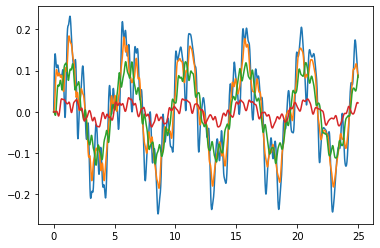

In [188]:
plt.plot(time,nonlin_response[:,n-1])
plt.plot(time,nonlin_response[:,n-2])
plt.plot(time,nonlin_response[:,n-3])
plt.plot(time,nonlin_response[:,n-5])

<h4 id="Extract-Tip-Position">Extract Tip Positions</h4>

In [145]:
# x_nonlin,y_nonlin = get_xy_coords(n,nonlin_response,lengths)
x_nonlin,y_nonlin = get_xy_coords(n,nonlin_response,lengths)

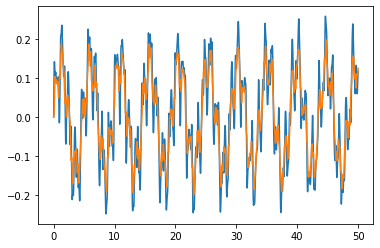

In [146]:
plt.plot(time,nonlin_response[:,n-1])
plt.plot(time,nonlin_response[:,n-2])

In [150]:
x = x_nonlin
y = y_nonlin

In [151]:
x.shape

(5000, 6)

<h3 id="Animate-the-Results">Animate the Results</h3>

In [152]:
%%capture
fps = int(np.round(1 / dt))

FFMpegWriter = writers['ffmpeg']


def update_lines(num, x,y):
    lines.set_data(x[num],y[num])
    return lines

# Attaching 3D axis to the figure
fig = plt.figure()
ax = plt.gca()

#data = np.array([x,y])

# Setting the axes properties

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')

def init():
    ax.set_ylim([-L, L])
    ax.set_xlim([-L, L])
#     plt.axes().set_aspect('equal')
    return lines,


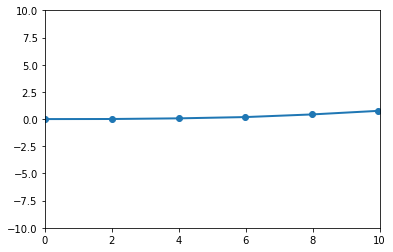

In [153]:
ax.set_title('Nonlinear Response')

fig, ax = plt.subplots()
xdata, ydata = [], []
lines, = ax.plot([], [], 'o-', lw=2)

def init():
    ax.set_xlim(0.,L)
    ax.set_ylim(-L,L)
    return lines,

def update(frame):
    xdata = x[frame]
    ydata = y[frame]
    lines.set_data(xdata, ydata)
    return lines,

ani = FuncAnimation(fig, update, 
                    frames=fps * int(np.amax(time)), # Use a number of frames based on the framerate and length of the time array
                    interval=fps,
                    
                    init_func=init, blit=True)

# Change the video bitrate as you like and add some metadata.
writer = FFMpegWriter(codec="h264", fps=fps, bitrate=-1, metadata=metadata)

ani.save(
    'test.mp4', # Set the file name
    dpi=240,          # Bump up to 4K resolution 3840x2160
    writer=writer,
    savefig_kwargs={
                'transparent': False, # h264 doesn't seem to like transparency 
                'facecolor': 'none'})
plt.show()

# # Create the animation
# anim_nonlinear = animation.FuncAnimation(
#                     fig, # Use the predefined figure
#                     update_lines, # Call the update function
#                     frames=fps * int(np.amax(time)), # Use a number of frames based on the framerate and length of the time array
#                     interval=fps,
#                     fargs = (x,y,lines),
#                     init_func=init,
#                     blit=False)

# plt.show()

# # We can also add some metadata to the video.
# metadata = dict(title='Catheter Model Animation', artist='Daniel Newman',
#                 comment='Shows a controlled catheter model in periodic flow.')

# # Change the video bitrate as you like and add some metadata.
# writer = FFMpegWriter(codec="h264", fps=fps, bitrate=-1, metadata=metadata)

ani.save(
    'animation-nonlinear.mp4', # Set the file name
    dpi=240,          # Bump up to 4K resolution 3840x2160
    writer=writer,
    savefig_kwargs={
                'transparent': False, # h264 doesn't seem to like transparency 
                'facecolor': 'none'})

In [154]:
HTML("""
<div align="middle">
<video width="100%" controls>
      <source src="test.mp4" type="video/mp4">
</video></div>""")

In [117]:
ax.set_title('Linear Response')


# Create the animation
anim_linear = animation.FuncAnimation(
                    fig, # Use the predefined figure
                    update_lines, # Call the update function
                    frames=fps * int(np.amax(time)), # Use a number of frames based on the framerate and length of the time array
                    interval=fps,
                    fargs = (x_linear,y_linear,lines),
                    blit=False)

# We can also add some metadata to the video.
metadata = dict(title='Catheter Model Animation', artist='Daniel Newman',
                comment='Shows a controlled catheter model in periodic flow.')

# Change the video bitrate as you like and add some metadata.
writer = FFMpegWriter(codec="h264", fps=fps, bitrate=-1, metadata=metadata)

anim_linear.save(
    'animation-linear.mp4', # Set the file name
    dpi=240,          # Bump up to 4K resolution 3840x2160
    writer=writer,
    savefig_kwargs={
                'transparent': False, # h264 doesn't seem to like transparency 
                'facecolor': 'none'})

In [118]:
HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="animation-linear.mp4" type="video/mp4">
</video></div>""")

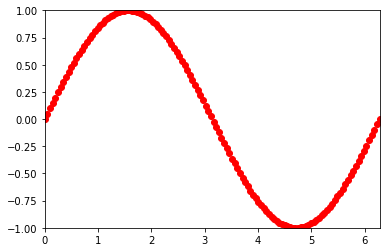

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], 'ro')

def init():
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-1, 1)
    return ln,

def update(frame):
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True)

# Change the video bitrate as you like and add some metadata.
writer = FFMpegWriter(codec="h264", fps=fps, bitrate=-1, metadata=metadata)

ani.save(
    'test.mp4', # Set the file name
    dpi=240,          # Bump up to 4K resolution 3840x2160
    writer=writer,
    savefig_kwargs={
                'transparent': False, # h264 doesn't seem to like transparency 
                'facecolor': 'none'})
plt.show()

In [45]:
HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="test.mp4" type="video/mp4">
</video></div>""")

<h2 id="Conclusion">Conclusion</h2>

<p>In this notebook, we analyzed and derived the equations of motion for a catheter and compared the linear and nonlinear models. As demonstrated, the linearized model performed very similarly to the full nonlinear equations. In future work, we will look exclusively at the linearized model.</p>

In [43]:
# This cell will just improve the styling of the notebook
from IPython.display import Image 
import urllib.request
response = urllib.request.urlopen("https://raw.githubusercontent.com/danielnewman09/Thesis-Notebooks/master/Styling/IpythonNotebook.css")
HTML(response.read().decode("utf-8"))

HTTPError: HTTP Error 404: Not Found